<a href="https://colab.research.google.com/github/ESSI-Lab/dab-pynb/blob/main/dab_demo_his_central.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to the Jupyter notebook example showing programmatically discovery and accesso of HIS-Central data**

This notebook is used to programmatically access HIS-Central DAB functionalities, in this case through the OGC OM-JSON based API, documented and available for tests also here: https://his-central.geodab.eu/gs-service/om-api

As a prerequisite to obtain programmatically access to HIS-Central, a token is required. It can be obtained after registration with ISPRA.

The HIS-central portal can also be used to help debug your python notebook: https://his-central.geodab.eu/gs-service/hisc/search.html

In [4]:
import urllib.parse
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import userdata
import requests


token = userdata.get('token-his-central')
view = 'his-central'
baseURL = 'https://his-central.geodab.eu/gs-service/services/essi/token/'

apiURL = baseURL + token + '/view/' + view + '/om-api/'



In [1]:
def obfuscate_token(text, token):
    """
    Replaces the token in the given string with '***'.

    Parameters:
        text (str): The string containing the token to obfuscate.
        token (str): The token to obfuscate.

    Returns:
        str: The string with the token replaced by '***'.
    """
    return text.replace(token, "***")

In [ ]:
# clear constraints
bbox = ""
temporal = ""
observedProperty = ""
ontology = ""

In [7]:
# observed property
observedProperty = "&observedProperty="+urllib.parse.quote("livello")
ontology="&ontology=his-central"

**First, we search for stations in the Tuscany area**

In [5]:
# Tuscany example
south = 42.425
west = 9.844
north = 43.981
east = 11.625

bbox = "&west="+str(west)+"&south="+str(south)+"&east="+str(east)+"&north="+str(north)

In [8]:
url = apiURL+"features?"+observedProperty+ontology+bbox
print("Retrieving "+obfuscate_token(url,token))
response = requests.get(url)

if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    sites = []
    if 'results' not in data:
        print("No results found")
    else:
      for site in data['results']:

          coordinates = site['shape']['coordinates']
          source = next(param['value'] for param in site['parameter'] if param['name'] == 'source')
          identifier = next(param['value'] for param in site['parameter'] if param['name'] == 'identifier')
          name = site['name']
          site_id = site['id']
          if 'relatedParty' in site and site['relatedParty']: # Add this check
            contact_name = site['relatedParty'][0].get('individualName',None)
            contact_email = site['relatedParty'][0].get('electronicMailAddress',None)
          else:
            contact_name = ""
            contact_email = ""


          sites.append({
              'Name': name,
              'ID': site_id,
              'Coordinates': f"{coordinates[0]}, {coordinates[1]}",
              'Source': source,
              'Identifier': identifier,
              'Contact Name': contact_name,
              'Contact Email': contact_email
          })

      # Create a DataFrame for tabular display
      df = pd.DataFrame(sites)

      styled_df = df.style.set_properties(**{
          'text-align': 'left',  # Align text to the left
          'border': '1px solid black',  # Add borders
          'padding': '5px'  # Add padding
      }).set_table_styles([
          {"selector": "th", "props": [("text-align", "left")]}
      ])

      # Display the table
      display(styled_df)

else:
    print("HTTP GET request failed with status code:", response.status_code)

Retrieving https://his-central.geodab.eu/gs-service/services/essi/token/***/view/his-central/om-api/features?&observedProperty=livello&ontology=his-central&west=9.844&south=42.425&east=11.625&north=43.981


,Name,ID,Coordinates,Source,Identifier,Contact Name,Contact Email
0,ASA 34,000777533B7C1AE90F783B87E98A60288F1D534B,"10.4996018448, 43.6238000685",Toscana,TOS19000650,,
1,S. Piero a Sieve-Carza,0088B2100397704EF0F749980C75411A3F011139,"11.3223473976022, 43.9590577674834",Toscana,TOS01004623,,
2,Piez. Guardamare,00A0C56B2595EBB08798BC00DC6C787B76EFA97E,"10.549, 43.07805",Toscana,TOS29000027,,
3,SP Lodano,00A6A0C1B93247FB96D25F1BFBC017683469FA89,"10.724056583658, 43.1115868263753",Toscana,TOS01005461,,
4,Dep. Cascina,0161FD29573348C2E060AFDC730CA3C5BAC0FE31,"10.488076258, 43.6750749442",Toscana,TOS19000646,,
5,Capannoli,0176D33D89C6555801C137622D7AE3BF7C9C59F1,"10.6844192154688, 43.5922849536088",Toscana,TOS01005131,,
6,S. Caterina,01D93E455BE1A3D889B9ABC1D6ED7EA32BAF24C4,"10.6797067853, 43.0380480392",Toscana,TOS19000640,,
7,Ponsacco,03876FBA646FF3E0694A6A02D9BD382ECF4DA5DA,"10.6339877843492, 43.6198249873421",Toscana,TOS01005151,,
8,RMS 51,0704017DAC4E2E4CEDB41F1047CE672C2E7CA156,"10.31382, 43.6225",Toscana,TOS29000037,,
9,Solvay,07F3C2F28BE6766FCA131C64E40575713362B399,"10.433052778244, 43.3822165515063",Toscana,TOS20000001,,


**Then we select a specific station to list its available observations**



In [9]:
# feature of Tuscany

featureId = "03876FBA646FF3E0694A6A02D9BD382ECF4DA5DA"

In [11]:

url = apiURL +"observations?feature="+featureId+observedProperty+ontology+bbox
print("Retrieving "+obfuscate_token(url,token))
response = requests.get(url)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    #print(data)

    observations = []
    for observation in data['member']:
        source = next(param['value'] for param in observation['parameter'] if param['name'] == 'source')
        observed_property_definition = next(param['value'] for param in observation['parameter'] if param['name'] == 'observedPropertyDefinition')
        original_observed_property = next(param['value'] for param in observation['parameter'] if param['name'] == 'originalObservedProperty')
        observed_property = observation['observedProperty']['title']
        phenomenon_time_begin = observation['phenomenonTime']['begin']
        phenomenon_time_end = observation['phenomenonTime']['end']
        feature_of_interest_href = observation['featureOfInterest']['href']
        observation_id = observation['id']
        observation_type = observation['type']
        uom = observation['result']['defaultPointMetadata']['uom']
        interpolation_type = observation['result']['defaultPointMetadata']['interpolationType']['title']

        observations.append({
            'Source': source,
            'Observed Property Definition': observed_property_definition,
            'Original Observed Property': original_observed_property,
            'Observed Property': observed_property,
            'Phenomenon Time Begin': phenomenon_time_begin,
            'Phenomenon Time End': phenomenon_time_end,
            'Feature of Interest Href': feature_of_interest_href,
            'Observation ID': observation_id,
            'Observation Type': observation_type,
            'Unit of Measurement': uom,
            'Interpolation Type': interpolation_type
        })

    # Create a DataFrame for tabular display
    df = pd.DataFrame(observations)

    # Display the table
    display(df)

else:
    print("HTTP GET request failed with status code:", response.status_code)

Retrieving https://his-central.geodab.eu/gs-service/services/essi/token/***/view/his-central/om-api/observations?feature=03876FBA646FF3E0694A6A02D9BD382ECF4DA5DA&observedProperty=livello&ontology=his-central&west=9.844&south=42.425&east=11.625&north=43.981


,Source,Observed Property Definition,Original Observed Property,Observed Property,Phenomenon Time Begin,Phenomenon Time End,Feature of Interest Href,Observation ID,Observation Type,Unit of Measurement,Interpolation Type
0,Toscana,Livello (m szi),Livello,Level,2008-01-01T00:00:00Z,2025-11-25T12:38:59Z,03876FBA646FF3E0694A6A02D9BD382ECF4DA5DA,535D2750E5839E426055F56F93C494C2BFBE7696,TimeSeriesObservation,m szi,Total


In [12]:
# Observation of Tuscany, Ponsacco
observationId = "535D2750E5839E426055F56F93C494C2BFBE7696"
beginPosition="&beginPosition="+urllib.parse.quote("2025-01-01T00:00:00Z")
endPosition="&endPosition="+urllib.parse.quote("2025-02-01T00:00:00Z")

**Finally, data from the specified observation is retrieved and plotted**

Retrieving https://his-central.geodab.eu/gs-service/services/essi/token/***/view/his-central/om-api/observations?includeData=true&observationIdentifier=535D2750E5839E426055F56F93C494C2BFBE7696&beginPosition=2025-01-01T00%3A00%3A00Z&endPosition=2025-02-01T00%3A00%3A00Z


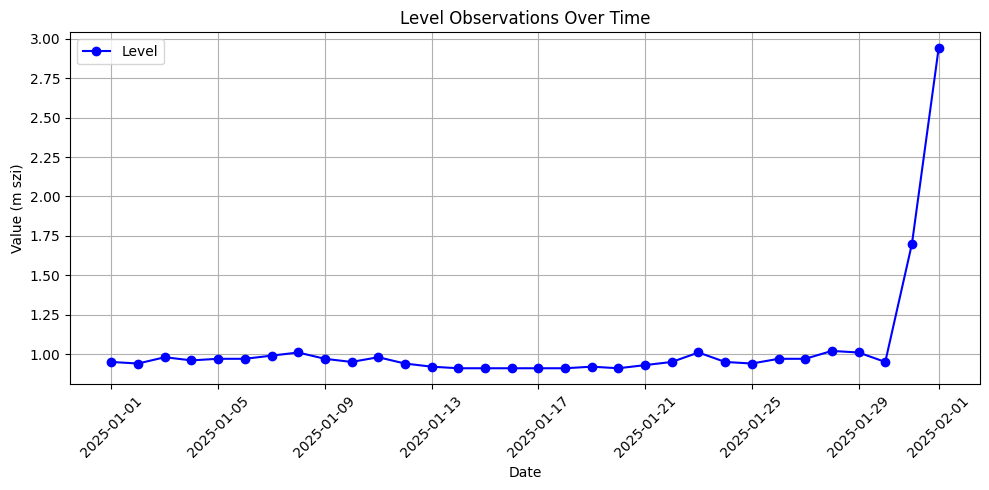

In [13]:
observation="&observationIdentifier="+urllib.parse.quote(observationId)

url = apiURL+"observations?includeData=true"+observation+beginPosition+endPosition
print("Retrieving "+obfuscate_token(url,token))
response = requests.get(url)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    # Extract the points
    points = data['member'][0]['result']['points']

    # Extract time and values
    times = [datetime.fromisoformat(point['time']['instant'].replace("Z", "+00:00")) for point in points]
    values = [point['value'] for point in points]

    # Get feature name and observed property
    # Access the feature_name variable set in the previous cell (7pBbhhLxXkac)
    # The observed_property_name is available in the current data response
    observed_property_name = data['member'][0]['observedProperty']['title']
    unit_of_measurement = data['member'][0]['result']['defaultPointMetadata']['uom']


    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(times, values, marker='o', linestyle='-', color='b', label=observed_property_name)
    plt.title(f'{observed_property_name} Observations Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'Value ({unit_of_measurement})')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


else:
    print("HTTP GET request failed with status code:", response.status_code)